In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
%matplotlib inline
df = pd.read_csv('listings_SanFan.csv')

# u'zipcode',u'location_price',,u'instant_bookable', u'host_is_superhost',u'host_response_rate',
selected_features = [u'price',u'accommodates',u'host_response_time',
       u'bathrooms', u'bedrooms', u'beds',u'security_deposit', u'cleaning_fee', u'guests_included',
       u'extra_people', u'minimum_nights', u'maximum_nights',u'guests_included',  
       u'availability_365',
       u'number_of_reviews', u'review_scores_rating',u'review_scores_cleanliness', u'review_scores_checkin',
       u'review_scores_communication', u'review_scores_location',
       u'review_scores_value', u'house_rules',u'amenities','bed_type', 'room_type', 'cancellation_policy', 'property_type']
df = df.loc[:, selected_features]
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.head()

,price,accommodates,host_response_time,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,house_rules,amenities,bed_type,room_type,cancellation_policy,property_type
0,$56.00,4,within an hour,1.0,1.0,2.0,$100.00,$30.00,2,$15.00,...,10.0,10.0,10.0,10.0,- Private bathroom is on the first floor (slig...,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",Real Bed,Private room,moderate,House
1,$36.00,2,within an hour,1.0,1.0,1.0,$100.00,$35.00,1,$20.00,...,10.0,10.0,10.0,10.0,1. NO SMOKING! This rule applies for inside ou...,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",Real Bed,Private room,strict,Condominium
2,$80.00,6,within an hour,1.5,2.0,3.0,$150.00,$65.00,4,$15.00,...,10.0,10.0,10.0,10.0,"I don't ask much, just to please respect the s...","{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Real Bed,Private room,moderate,Townhouse
3,$80.00,2,within a few hours,1.0,1.0,1.0,$100.00,$10.00,2,$10.00,...,10.0,10.0,10.0,10.0,Guests should treat my condo as their home wit...,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Real Bed,Private room,flexible,Condominium
4,$20.00,3,within an hour,1.0,1.0,1.0,$100.00,$50.00,1,$10.00,...,10.0,10.0,10.0,9.0,If using the kitchen please clean up after you...,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Real Bed,Private room,strict,Apartment


In [3]:
df['price'] = df['price'].str.replace("\$|,", "").astype(float)
df['security_deposit'] = df['security_deposit'].str.replace("\$|,", "").astype(float)
df['cleaning_fee'] = df['cleaning_fee'].str.replace("\$|,", "").astype(float)
df['extra_people'] = df['extra_people'].str.replace("\$|,", "").astype(float)
df['availability'] = df['availability_365'] / 365

C:\Users\Intel\AppData\Local\Temp\ipykernel_16528\2738635161.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace("\$|,", "").astype(float)
C:\Users\Intel\AppData\Local\Temp\ipykernel_16528\2738635161.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['security_deposit'] = df['security_deposit'].str.replace("\$|,", "").astype(float)
C:\Users\Intel\AppData\Local\Temp\ipykernel_16528\2738635161.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleaning_fee'] = df['cleaning_fee'].str.replace("\$|,", "").astype(float)
C:\Users\Intel\AppData\Local\Temp\ipykernel_16528\2738635161.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['extra_people'] = df['extra_people'].str.replace("\$|,", "").astype(float)


In [4]:
house_rules = df['house_rules'].str.lower()

smoking = house_rules.str.contains("smoke|smoking", na= False)
df.loc[:, 'smoking'] = - smoking # False: No smoking allowed

pet = house_rules.str.contains("pet", na=False)
df.loc[:, 'pet'] = - pet

party = house_rules.str.contains("party|parties", na=False)
df.loc[:, 'party'] = - party

guest = house_rules.str.contains("guest|guests", na=False)
df.loc[:, 'guest'] = - guest

df = df.drop(['house_rules'], axis = 1)

In [5]:
import re
# AMENITIES
amenities = list(df['amenities'])
total = ','.join(amenities)
total = total.replace("{", "").replace("}","").replace("\"", "").split(",")
amenity_items = list(set(total))
amenity_items = list(filter(None, amenity_items))
for item in amenity_items:
    if re.match(r'translation',item):
        amenity_items.remove(item)

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

amenities = list(df['amenities'])
new_table = pd.DataFrame(index = df.reset_index().values[:,0], columns = amenity_items).fillna(0)

for i in range(len(amenities)):
    for item in amenity_items:
        if item in amenities[i]:
            new_table.at[i, item] = 1  

sum_table = np.array(new_table.sum())
ind = (-sum_table).argsort()[:60]
common_amenities = list(new_table.sum().iloc[ind].index)
df = df.drop(['amenities'], axis = 1)
df = pd.concat([df, new_table[common_amenities]], axis = 1)


In [7]:
columns = ['bed_type', 'room_type', 'cancellation_policy', 'property_type', 'host_response_time']
for column in columns:  
    unique_values = list(df[column].unique())
    column_list = list(df[column])
    new_table = pd.DataFrame(index = df.reset_index().values[:,0], columns = unique_values).fillna(0)
    
    for i in range(len(column_list)):
        for item in unique_values:
            if item in column_list[i]:
                new_table.at[i, item] = 1  # Correct usage of .at method
                
    df = pd.concat([df, new_table], axis = 1)
    df = df.drop([column], axis = 1)


[0.06955685 0.06390113 0.03772549 0.0358486  0.02982785 0.02430287
 0.02028962 0.01951864 0.01782744 0.01724031 0.01602385 0.01572047
 0.01438599 0.01385817 0.01359818 0.01263157 0.01250308 0.01209182
 0.01166597 0.01149772 0.01051485 0.01049485 0.01003396 0.0098979
 0.0097298  0.0096207  0.00942681 0.00920785 0.0091321  0.00908682
 0.008852   0.008788   0.00869415 0.00863076 0.00857691 0.00852736
 0.00846219 0.00837228 0.00828382 0.00825902 0.00824112 0.00816129
 0.00808632 0.00802211 0.00791165 0.00786486 0.00779081 0.00771435
 0.0075934  0.00756963]


array([[ 0.26131529,  0.14553921, -0.63535322, ..., -0.37683547,
        -1.40709974, -0.98389924],
       [-0.22706446,  0.27147553,  0.89444124, ..., -0.37876072,
        -0.38470117, -1.08282932],
       [ 2.80348141, -2.91123738, -1.96729073, ..., -1.26146406,
        -0.51066367, -0.61061191],
       ...,
       [-0.48489162,  0.64256301, -0.01337113, ..., -0.0487405 ,
         1.10293897, -0.62116449],
       [-1.39984731,  1.1676076 , -2.57622419, ..., -3.26742921,
         0.88278303,  0.84856444],
       [-0.66719616, -0.02971274,  1.72804394, ...,  0.08000023,
         0.15306461,  0.57979772]])

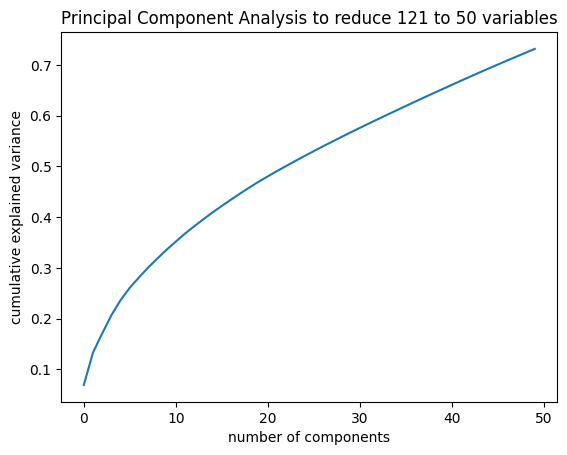

In [8]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
# df.drop(['longitude','latitude'], axis=1, inplace=True)
X = np.array(df.drop(['price'], axis = 1))
X_scaled = preprocessing.scale(X)
y =df['price']
pca = PCA(n_components=50)
X_scaled = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Principal Component Analysis to reduce 121 to 50 variables')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
X_scaled

[0 0 2 ... 0 0 0]


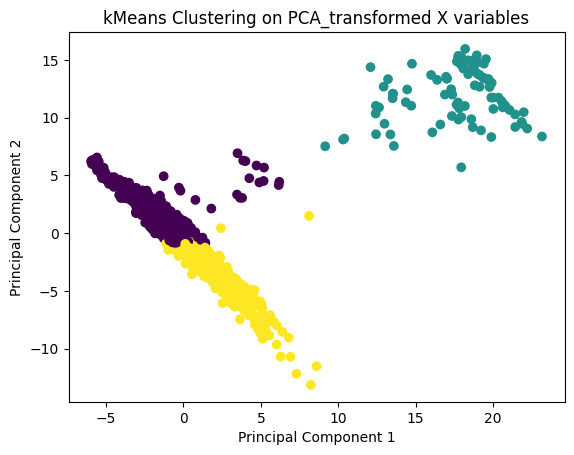

In [9]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=3, random_state=170).fit_predict(X_scaled)
print(y_pred)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred)
plt.title("kMeans Clustering on PCA_transformed X variables")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [10]:
y_pred
ind1= np.where(y_pred == 1)
ind1

(array([   9,  396,  399,  462,  464,  465,  466,  467,  468,  480,  481,
         503,  513,  543,  546,  710,  812, 1071, 1072, 1139, 1157, 1202,
        1203, 1340, 1371, 1453, 1460, 1496, 1528, 1576, 2025, 2079, 2216,
        2260, 2421, 2764, 2845, 2850, 2884, 2892, 2920, 2929, 2954, 2960,
        2992, 3028, 3067, 3239, 3279, 3281, 3287, 3318, 3330, 3378, 3524,
        3595, 3597, 3598, 3655, 3833, 3897, 3913, 4001, 4137, 4167, 4350,
        4487, 4496, 4521, 4522, 4525, 4611, 4624, 4625, 4632, 4635, 4641,
        4642, 4654, 4740, 4874, 4959, 4977, 4987, 5025, 5047, 5131, 5199],
       dtype=int64),)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

cluster_data=df.iloc[:,2:]  # Correct usage of .iloc
X=cluster_data
y=df.loc[:,'price']  # Use .loc instead of .iloc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tunedParameters=[{'n_estimators':range(50,100,10)}]
clf=GridSearchCV(RandomForestRegressor(n_jobs = -1, criterion='mse'), param_grid = tunedParameters,cv=10)

clf.fit(X, y)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppDa

C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Intel\AppDa

0.330 (+/-0.297) for {'n_estimators': 50}
0.343 (+/-0.222) for {'n_estimators': 60}
0.383 (+/-0.214) for {'n_estimators': 70}
0.387 (+/-0.206) for {'n_estimators': 80}
0.349 (+/-0.260) for {'n_estimators': 90}


C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\skl

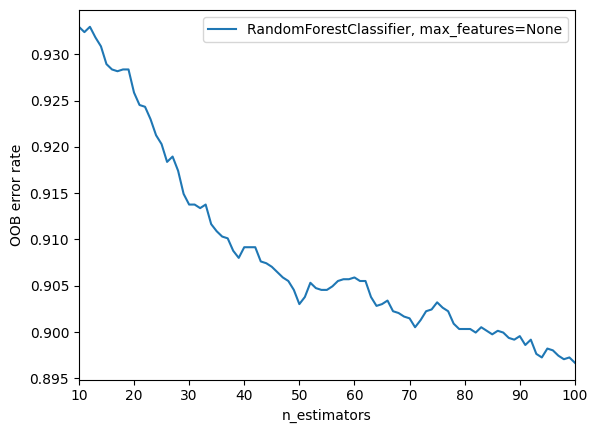

C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RandomForestRegressor(criterion='mse', n_jobs=1)

In [12]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
ensemble_clfs = [("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=0))]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

from sklearn.ensemble import RandomForestRegressor

X=cluster_data
y=df.loc[:,'price']  # Use .loc instead of .ix
tunedParameters = [{'n_estimators':100}]

clf2 = RandomForestRegressor(n_jobs = 1, criterion='mse', n_estimators=100)
#Fit Model
clf2.fit(X, y)


In [13]:
FeatImp = pd.DataFrame({'feature': list(X.columns), 'importance': list(clf2.feature_importances_)})
FeatImp = FeatImp.sort_values('importance', ascending = False)
#Set Index To Field You want to Sort Bar Chart By
FeatImp = FeatImp.set_index('feature')
FeatImp.head(100)
FeatImp.to_csv('feature_imp.csv')

In [14]:
FeatImp.index[0:30]

Index(['bedrooms', 'bathrooms', 'security_deposit', 'Boat', 'extra_people',
       'cleaning_fee', 'beds', 'minimum_nights', 'availability',
       'availability_365', 'Entire home/apt', 'number_of_reviews',
       'Hair dryer', 'within a day', 'maximum_nights', 'Elevator in building',
       'Essentials', 'Hangers', '24-hour check-in', 'guests_included', 'Iron',
       'flexible', 'Suitable for events', 'First aid kit',
       'Laptop friendly workspace', 'guests_included', 'Doorman Entry',
       'review_scores_rating', 'Wheelchair accessible', 'within an hour'],
      dtype='object', name='feature')

In [15]:
FeatImp['importance'].values[0:30]

array([0.12474385, 0.09923083, 0.08547958, 0.07862422, 0.07231882,
       0.06595047, 0.05364326, 0.05095622, 0.03621102, 0.0322013 ,
       0.02703814, 0.02481318, 0.0138803 , 0.01307244, 0.01230292,
       0.01085705, 0.00962192, 0.00887469, 0.00718216, 0.00711256,
       0.00693089, 0.00666272, 0.00587851, 0.00567133, 0.0056423 ,
       0.00537038, 0.00487901, 0.00466771, 0.00426477, 0.00413607])

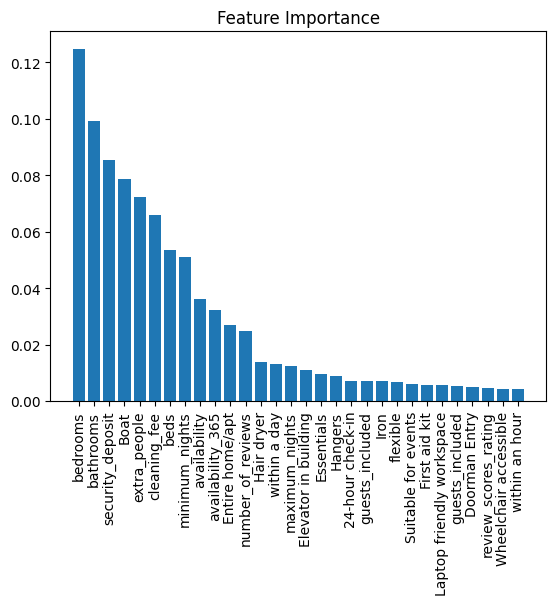

In [16]:
import matplotlib.pyplot as plt
plt.figure()

plt.title("Feature Importance")
y_pos = np.arange(len(FeatImp.index[0:30]))
plt.bar(y_pos,FeatImp['importance'].values[0:30])
plt.xticks(y_pos, FeatImp.index[0:30],rotation='vertical')
plt.show()

C:\Users\Intel\AppData\Local\Temp\ipykernel_16528\3582954755.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


54.4

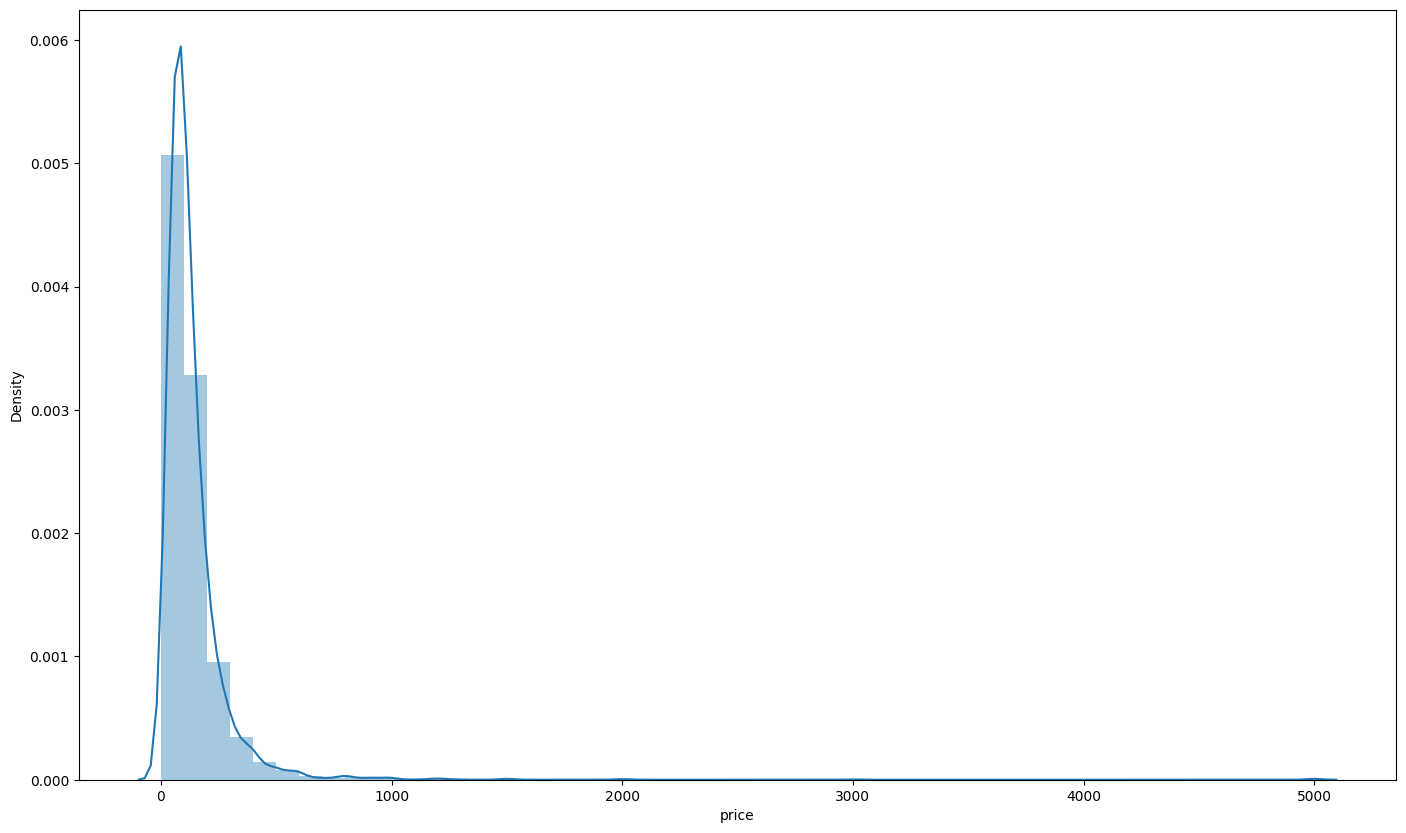

In [17]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(17,10))
# df['price'] = df.price.str.replace("\$|,", "").astype(float)
# df['price'].hist()
sns.distplot(df['price'])
# plt.show()
mean_price = df.price.iloc[:5].mean()
mean_price
# df['host_acceptance_rate'].head()

C:\Users\Intel\AppData\Local\Temp\ipykernel_16528\1800941916.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['review_scores_rating'])


<AxesSubplot:xlabel='review_scores_rating', ylabel='Density'>

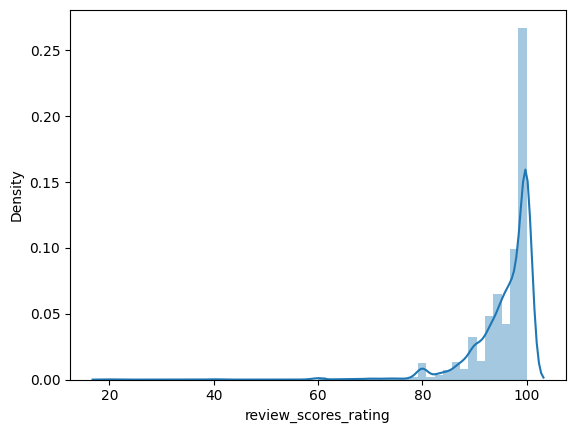

In [18]:
df['review_scores_rating'].fillna(0, inplace=True)
df['review_scores_rating'].dropna(axis=0, inplace=True)
sns.distplot(df['review_scores_rating'])

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

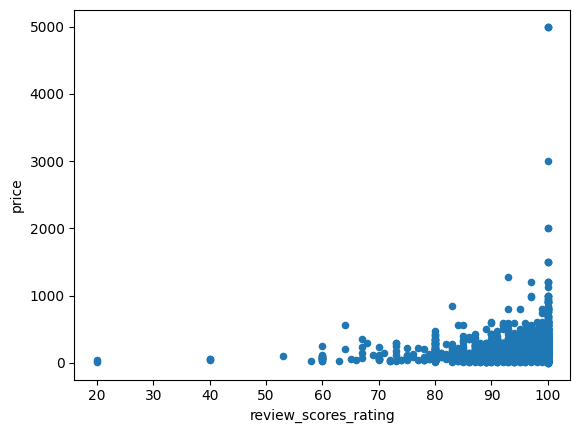

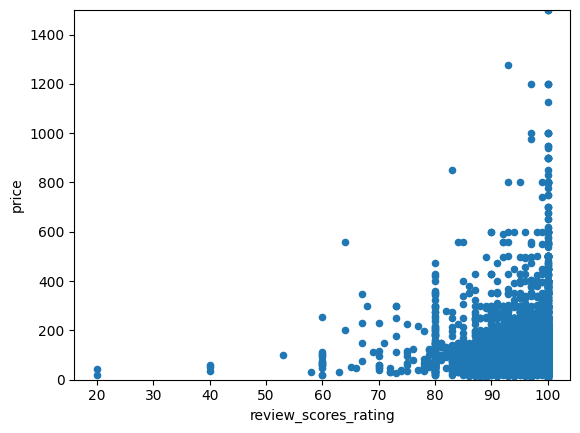

In [19]:
#Correlation Plot
var = 'review_scores_rating'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price')
data.plot.scatter(x=var, y='price', ylim=(0,1500))

In [20]:
x=df.drop('price',axis=1)
y=df['price']


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=101)

In [23]:
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled=scaler.fit_transform(x_test)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [25]:
log_model=LogisticRegression(solver='saga',multi_class='auto')

In [26]:
log_model.fit(x_train_scaled,y_train)

C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

In [27]:
penalty=['l1','l2']
C=np.logspace(0,4,10)

In [28]:
grid=GridSearchCV(log_model,param_grid={'penalty':penalty})

In [29]:
grid.fit(x_train_scaled,y_train)

C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\U

GridSearchCV(estimator=LogisticRegression(solver='saga'),
             param_grid={'penalty': ['l1', 'l2']})

In [30]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix

In [31]:
y_pred=grid.predict(x_test_scaled)

In [32]:
accuracy_score(y_test,y_pred)*100

7.165706973768395

In [33]:
confusion_matrix(y_test,y_pred)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        12.0       0.00      0.00      0.00         1
        14.0       0.00      0.00      0.00         1
        15.0       0.56      0.62      0.59         8
        16.0       0.00      0.00      0.00         1
        17.0       0.00      0.00      0.00         0
        18.0       0.00      0.00      0.00         1
        19.0       0.50      0.75      0.60         4
        20.0       0.00      0.00      0.00         1
        22.0       0.00      0.00      0.00         3
        23.0       0.00      0.00      0.00         3
        25.0       0.20      0.29      0.24         7
        27.0       1.00      0.50      0.67         2
        28.0       0.00      0.00      0.00         5
        29.0       0.00      0.00      0.00         5
        30.0       0.09      0.11      0.10         9
        31.0       0.00    

C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Intel\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

In [35]:
from sklearn import model_selection

array = df.values
x = array[:,0:4]
y = array[:,4]
validation_size = 0.20
seed = 6
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=validation_size, random_state=seed)


In [43]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_test[:1000], y_pred[:1000])
mse = metrics.mean_squared_error(y_test[:1000], y_pred[:1000])
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test[:1000],y_pred[:1000])

print("Results by manual calculation:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results by manual calculation:
MAE: 119.062
MSE: 21242.434
RMSE: 145.74784389485836
R-Squared: -9944.350847130692


In [44]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_test[:1000], y_pred[:1000])
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

145.74784389485836
